In [1]:
machine = 'mac'
machine = 'magny'

Ngalrad = 4.
dR = 1# kpc
dz = 2# kpc

In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import copy

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind

from auriga_basics import *
from auriga_functions import *
%matplotlib inline

In [3]:
cmap = copy.copy(plt.cm.inferno)
cmap.set_bad((0,0,0))  # Fill background with black

In [38]:
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*
level = 4
if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(127,128,1):
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[0,1,2,3,4,5], 
            haloid=0, galradfac=0.1, verbose=True) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
     

level   : 4
halo    : 24
snapnr  : 127
basedir : /hits/universe/GigaGalaxy/level4_MHD/
halodir : /hits/universe/GigaGalaxy/level4_MHD/halo_24/
snappath: /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/

[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated bfld.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]



In [ ]:
nr = 20
nz = 30
galrad = 0.1 * sf.data['frc2'][0]
zmax = 0.005

na = s.nparticlesall
mass = s.data['mass'].astype('float64')
st = na[:4].sum(); en = st+na[4]
age = np.zeros( s.npartall )
age[st:en] = s.data['age']
rad = np.sqrt( (s.pos[:,1:]**2).sum(axis=1) )

iall, = np.where( (rad < galrad) & (rad > 0.) )
istars, = np.where( (rad < galrad) & (rad > 0.) & (s.type == 4) & (age > 0.) )
igas, = np.where( (rad < galrad) & (rad > 0.) & (s.type == 0) )
idm, = np.where( (rad < galrad) & (rad > 0.) & (s.type == 1) )

nstars = len( istars )
ngas = len( igas )
ndm = len( idm )
nall   = len( iall )

pos  = s.pos[iall,:].astype( 'float64' )
vel = s.vel[iall,:].astype( 'float64' )
mass = s.data['mass'][iall].astype( 'float64' )
ptype = s.data['type'][iall].astype('int32')
radius = np.sqrt( (s.pos[iall,1:]**2).sum(axis=1) )
pot = s.data['pot'][iall].astype('float64')
age = age[iall]

## For stars
smass = np.zeros( nstars )
star_age = np.zeros( nstars )
star_radius = np.zeros( nstars )
star_height = np.zeros( nstars )
eps2 = np.zeros(nstars)
jcmax = np.zeros(nstars)
spec_energy = np.zeros(nstars)

nn, = np.where((ptype[:] == 4) & (age[:] > 0.)) 

j  = np.cross( pos[nn,:], vel[nn,:] )
jz = j[:,0]
spec_energy[:] = 0.5 * (vel[nn,:]**2).sum(axis=1) + pot[nn]
eps2[:] = jz

smass[:] = mass[nn]
star_age[:] = s.cosmology_get_lookback_time_from_a( age[nn], is_flat=True )
star_radius[:] = radius[nn]
star_height[:] = pos[nn,0]

iensort = np.argsort(spec_energy)
smass = smass[iensort]
star_age = star_age[iensort]
star_height = star_height[iensort]
star_radius = star_radius[iensort]

#eps2 = discy.disc(eps2)

smass /= smass.sum()
jj, = np.where( (eps2 > 0.7) )
smass = smass[jj]
star_age = star_age[jj]
star_height = star_height[jj]
star_radius = star_radius[jj]

## For gas

gmass = np.zeros( ngas )
gas_radius = np.zeros( ngas )
gas_height = np.zeros( ngas )

mm, = np.where((ptype[:] == 0))

gmass[:] = mass[mm]
gas_radius[:] = radius[mm]
gas_height[:] = pos[mm,0]

## For dm

dmass = np.zeros( ndm )
dm_radius = np.zeros( ndm )
dm_height = np.zeros( ndm )

mm, = np.where((ptype[:] == 1))

dmass[:] = mass[mm]
dm_radius[:] = radius[mm]
dm_height[:] = pos[mm,0]

#smass *= 1e10

srad = np.zeros(nr)
sz = np.zeros(nz)
dr = galrad / float(nr)
dz = zmax / float(nz)
rbin = np.zeros(nr)
zbin = np.zeros(nz)

pn, xedges, yedges = np.histogram2d( star_radius, star_height, bins=(nr,nz), weights=smass, range=[[0., galrad],[0., zmax]] )

si = (nr,nz)
dv = np.zeros( nr )
rho = np.zeros( si )
rbin[:] = 0.5 * ( xedges[1:] + xedges[:-1] )
zbin[:] = 0.5 * ( yedges[1:] + yedges[:-1] )

## Stellar density
dv[:] = np.pi *( ( xedges[1:]**2 - xedges[:-1]**2 )*1e6 ) * ( dz * 1e3 )
dv = [dv] * nz
dv = np.array(dv)
dv = dv.T
rho[:,:] = pn[:,:] * 1e10 / dv[:,:]
rho[:,:] *= 1e-9   # /pc^3

## Gas+dm midplane density
kk, = np.where( (abs(gas_height) < 0.001 ) )
mg, edges = np.histogram( gas_radius[kk], bins=nr, range=(0., galrad), weights=gmass[kk] )
kk, = np.where( (abs(dm_height) < 0.001 ) )
mdm, edges = np.histogram( dm_radius[kk], bins=nr, range=(0., galrad), weights=dmass[kk] )
dv = np.pi *( ( xedges[1:]**2 - xedges[:-1]**2 )*1e6 ) * ( 0.001 * 1e3 )
rhog = np.zeros( nr )
eps0 = np.zeros( nr )
#rhog[:] = (mg[:] + mdm[:]) * 1e10 / dv[:]
rhog[:] = mg[:] * 1e10 / dv[:]

eps0[:] = rhog[:] / rho[:,0]

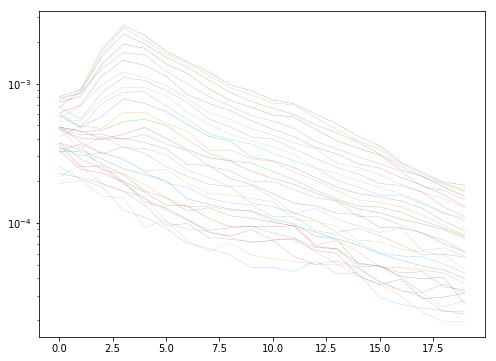

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.semilogy(rho,linestyle='-',lw=0.2)

computing star properties
computing histograms


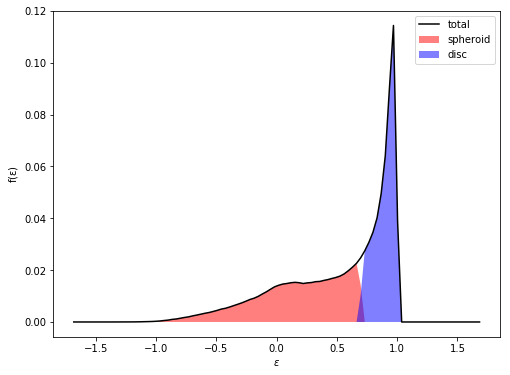

In [5]:
disk_ID, bulge_ID = decomp(s, plotter = True, disccirc = 0.75)

In [42]:
istars, = np.where( (s.type == 4) & (s.halo == 0) & (s.r() > 0.) & (s.r() < s.galrad) )
(x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, istars)
(R, phi, z), (vR, vphi, vz) = get_cylindrical_vectors(s, sf, istars)

In [7]:
diskmask = np.isin(s.id[istars], disk_ID)
bulgemask = np.isin(s.id[istars], bulge_ID)

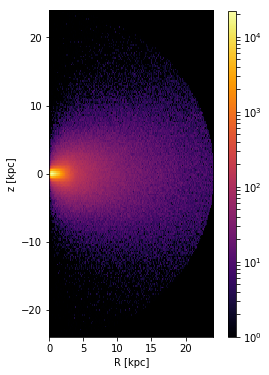

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
h = ax.hist2d(1000*R[bulgemask], 1000*z[bulgemask], bins=201, norm=matplotlib.colors.LogNorm(), cmap = cmap)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("z [kpc]")
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(h[3], cax=cax)


In [39]:
def dens(M, R, z, dR, dz):
    
    Rmin, Rmax = np.min(R), np.max(R)
    if Rmin == 0.:
        Rmin = np.sort(R)[1]
    zmin, zmax = np.min(z), np.max(z)
    if zmin == 0.:
        zmin = np.sort(z)[1]    
    print('Rmin:', Rmin, 'Rmax:', Rmax, 'dR:', dR)
    print('zmin:', zmin, 'zmax:', zmax, 'dz:', dz)
    Rbins, zbins = np.arange(Rmin, Rmax, dR), np.arange(zmin, zmax, dz)
    mbins, volbins = np.zeros((len(Rbins), len(zbins))), np.zeros((len(Rbins), len(zbins))) 
    rho_arr_real, rho_arr_mean = np.zeros(len(R)), np.zeros(len(R))
    for i in range(len(Rbins)):
        for j in range(len(zbins)):
            if i == 0:
                if (j < len(zbins) - 1):
                    inbin = (0 <= R) & (R < Rbins[i+1]) & (zbins[j] <= z) & (z < zbins[j+1])
                    mbins[i,j] = np.sum(M[inbin])
                    volbins[i,j] = np.pi * dz * (dR**2)
                    rho_arr_real[inbin] = mbins[i,j] / volbins[i,j] 
                    rho_arr_mean[inbin] = (mbins[i,j] / volbins[i,j]) / len(inbin) 
                elif j == len(zbins) - 1:
                    inbin = (0 <= R) & (R < Rbins[i+1]) & (zbins[j] <= z) & (z < (zbins[j] + dz))
                    mbins[i,j] = np.sum(M[inbin])
                    volbins[i,j] = np.pi * dz * (dR**2)
                    rho_arr_real[inbin] = mbins[i,j] / volbins[i,j] 
                    rho_arr_mean[inbin] = (mbins[i,j] / volbins[i,j]) / len(inbin) 
                else:
                    print(len(zbins), j)    
            elif (i > 0) & (i < len(Rbins) - 1):
                if j < len(zbins) - 1:
                    inbin = (Rbins[i] <= R) & (R < Rbins[i+1]) & (zbins[j] <= z) & (z < zbins[j+1])
                    mbins[i,j] = np.sum(M[inbin])
                    volbins[i,j] = np.pi * dz * (2. * Rbins[i] * dR + dR**2)
                    rho_arr_real[inbin] = mbins[i,j] / volbins[i,j] 
                    rho_arr_mean[inbin] = (mbins[i,j] / volbins[i,j]) / len(inbin) 
                elif j == len(zbins) - 1:
                    inbin = (Rbins[i] <= R) & (R < Rbins[i+1]) & (zbins[j] <= z) & (z < (zbins[j] + dz))
                    mbins[i,j] = np.sum(M[inbin])
                    volbins[i,j] = np.pi * dz * (2. * Rbins[i] * dR + dR**2)
                    rho_arr_real[inbin] = mbins[i,j] / volbins[i,j] 
                    rho_arr_mean[inbin] = (mbins[i,j] / volbins[i,j]) / len(inbin) 
                else:
                    print(len(zbins), j)
            elif i == len(Rbins) - 1:
                if j < len(zbins) - 1:
                    inbin = (Rbins[i] <= R) & (R < (Rbins[i] + dR)) & (zbins[j] <= z) & (z < zbins[j+1])
                    mbins[i,j] = np.sum(M[inbin])
                    volbins[i,j] = np.pi * dz * (2. * Rbins[i] * dR - dR**2)
                    rho_arr_real[inbin] = mbins[i,j] / volbins[i,j] 
                    rho_arr_mean[inbin] = (mbins[i,j] / volbins[i,j]) / len(inbin) 
                elif j == len(zbins) - 1:
                    inbin = (Rbins[i] <= R) & (R < (Rbins[i] + dR)) & (zbins[j] <= z) & (z < (zbins[j] + dz))
                    mbins[i,j] = np.sum(M[inbin])
                    volbins[i,j] = np.pi * dz * (2. * Rbins[i] * dR - dR**2)
                    rho_arr_real[inbin] = mbins[i,j] / volbins[i,j] 
                    rho_arr_mean[inbin] = (mbins[i,j] / volbins[i,j]) / len(inbin) 
                else:
                    print(len(zbins), j, len(Rbins), i)
            else:
                print(len(Rbins), i)
             

    rho = mbins/volbins
    return(rho, rho_arr_real, rho_arr_mean, Rbins, zbins)

In [72]:
rad = np.sqrt( (s.pos[:,1:]**2).sum(axis=1) )
iall, = np.where( (rad < galrad) & (rad > 0.) )
istars, = np.where( (rad < galrad) & (rad > 0.) & (s.type == 4) )#& (age > 0.) )
igas, = np.where( (rad < galrad) & (rad > 0.) & (s.type == 0) )
idm, = np.where( (rad < galrad) & (rad > 0.) & ((s.type == 1) + (s.type == 2) + (s.type == 3) ))

(x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, idm)
(R, phi, z), (vR, vphi, vz) = get_cylindrical_vectors(s, sf, idm)

dz = 1
rho, rho_arr_real, rho_arr_mean, Rbins, zbins = dens(s.mass[idm][np.abs(1000*z > -50.) & np.abs(1000*z <50.)], 1000*R[np.abs(1000*z > -50.) & np.abs(1000*z <50.)], 1000*z[np.abs(1000*z > -50.) & np.abs(1000*z <50.)], dR, dz)

(array([65572538, 65572539, 65572540, ..., 66143670, 66143671, 66143672]),)
(array([66143673, 66143674, 66143675, ..., 67013275, 67013276, 67013277]),)
[  2.12632891e-04   4.32593442e-05   2.29135127e-04 ...,   1.62569452e-02
   1.52023323e-02   2.29128674e-02]
Rmin: 0.00372548 Rmax: 24.0856 dR: 1
zmin: -49.9983 zmax: 49.9993 dz: 1


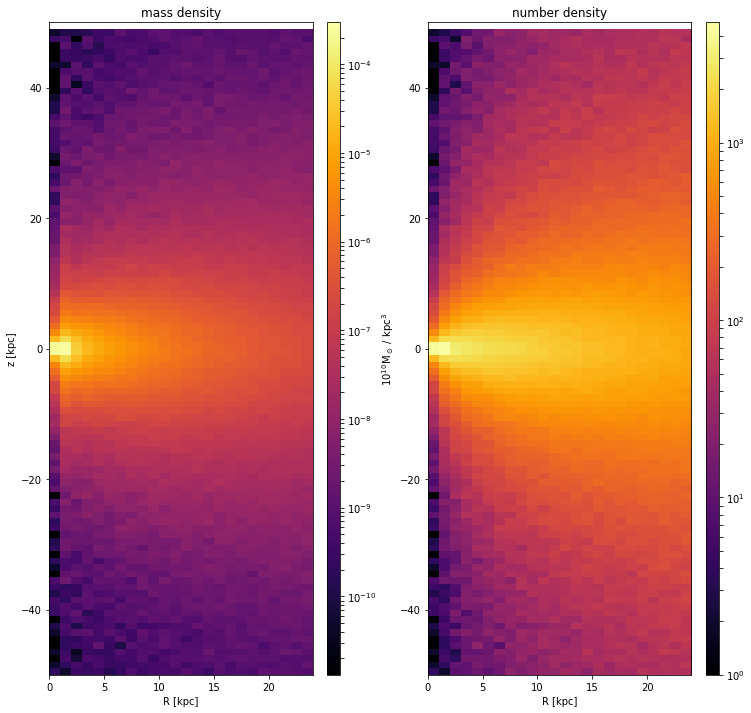

In [73]:

cmap = copy.copy(plt.cm.inferno)
cmap.set_bad((0,0,0))  # Fill background with black

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.3, hspace=None)
h1 = ax1.hist2d(1000*R[np.abs(1000*z > -50.) & np.abs(1000*z <50.)], 1000*z[np.abs(1000*z > -50.) & np.abs(1000*z <50.)], bins=[Rbins, zbins], weights = rho_arr_mean, range = [[0,25e-3],[-50e-3,50e-3]], norm=matplotlib.colors.LogNorm(), cmap = cmap)#, \
           #range = [[0, 25], [-25, 25]])
ax1.set_xlabel("R [kpc]")
ax1.set_ylabel("z [kpc]")
ax1.set_ylim(-50,50)
#ax1.set_aspect('equal')
ax1.set_title("mass density")
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.2)
cbar1 = fig.colorbar(h1[3], cax=cax1)
cbar1.set_label('$10^{10}\mathrm{M}_\odot\ /\ \mathrm{kpc}^3$')

h2 = ax2.hist2d(1000*R[np.abs(1000*z > -50.) & np.abs(1000*z <50.)], 1000*z[np.abs(1000*z > -50.) & np.abs(1000*z <50.)], bins=[Rbins, zbins], range = [[0,25e-3],[-50e-3,50e-3]], norm=matplotlib.colors.LogNorm(), cmap = cmap)
ax2.set_xlabel("R [kpc]")
#ax2.set_ylabel("z [kpc]")
#ax2.set_aspect('equal')
ax2.set_ylim(-50,50)

ax2.set_title('number density')
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.2)
cbar2 = fig.colorbar(h2[3], cax=cax2)
#cbar2.set_label('$\mathrm{N}\ / \ \mathrm{kpc}^3$')
 
#fig.savefig('../plots/au24_densities.png', dpi = 300, format = 'png', bbox_inches = 'tight')

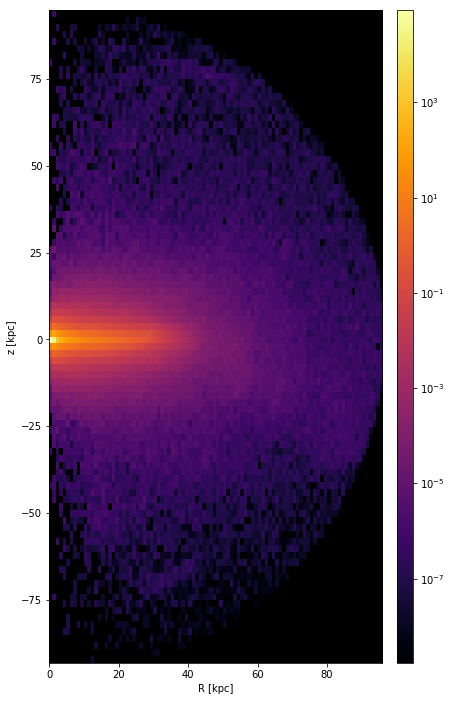

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
h = ax.hist2d(1000*R, 1000*z, bins=[Rbins, zbins], weights = np.array(rho_arr_real), norm=matplotlib.colors.LogNorm(), cmap = cmap)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("z [kpc]")
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(h[3], cax=cax)


In [9]:
print(np.max(rho), np.min(rho))
print()

0.219298686093 0.0



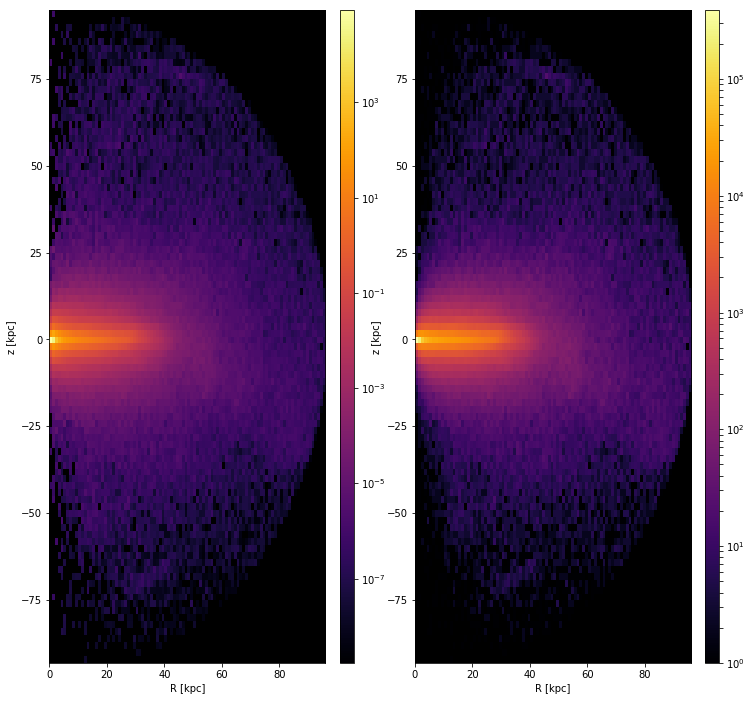

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
h1 = ax1.hist2d(1000*R, 1000*z, bins=[Rbins, zbins], weights = rho_arr_real, norm=matplotlib.colors.LogNorm(), cmap = cmap)
ax1.set_xlabel("R [kpc]")
ax1.set_ylabel("z [kpc]")
ax.set_aspect('equal')
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(h1[3], cax=cax1)
h2 = ax2.hist2d(1000*R, 1000*z, bins=[Rbins, zbins], norm=matplotlib.colors.LogNorm(), cmap = cmap)
ax2.set_xlabel("R [kpc]")
ax2.set_ylabel("z [kpc]")
ax.set_aspect('equal')
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(h2[3], cax=cax2)

In [11]:
print(rho_arr_mean)

[  1.06526725e-07   1.06526725e-07   1.06526725e-07 ...,   3.34668262e-11
   2.68065381e-12   1.17092305e-11]


In [12]:
print(rho_arr_real)

[  2.19298686e-01   2.19298686e-01   2.19298686e-01 ...,   6.88956785e-05
   5.51846364e-06   2.41049264e-05]


In [13]:
#np.savetxt('rhodata.txt', np.column_stack((rho_arr_mean, rho_arr_real)), header=('rho_mean, rho_real'))

In [14]:
print(np.min(rho_arr_mean), np.max(rho_arr_mean))

8.30513339598e-16 1.06526725152e-07


Try to distinguish stellar disc and bulge components by the use of the circularity parameter $\epsilon = \frac{L_z}{L_{z,max}(E)}$.

$L_{z,max}(E)$ is the maximum angular momentum allowed for the orbital energy $E$. 

$\rightarrow \epsilon = 1$ is a prograde circular orbit in the disc plane. $\epsilon = -1$ is a retrograde circular orbit in the disc plane. $\epsilon \sim 0$ is an orbit with a very low $z$-component of angular momentum which may be highly inclined to the disc spin axis and/or be highly eccentric.  

Two methods two distinguish the components:
1. Mirror negative $\epsilon$ as bulge material, rest disc components.
2. Assign $\epsilon > 0.7$ to disc star particles.

see Grand et al. 2017

In [32]:
# plot energy over Lz

def momentum(m, vx, vy, vz):
    px, py, pz = m*vx, m*vy, m*vz
    return(px, py, pz)

def ang_mom(x, y, z, vx, vy, vz, m):
    px, py, pz = momentum(m, vx, vy, vz)
    Lx = y * pz - z * py
    Ly = z * px - x * pz
    Lz = x * py - y * px
    return(Lx, Ly, Lz)

E = s.pot[istars] + 1./2. * s.mass[istars] * (vx**2 + vy**2)
Lx, Ly, Lz = ang_mom(x,y,z,vx,vy,vz,s.mass[istars])


Text(0,0.5,'E')

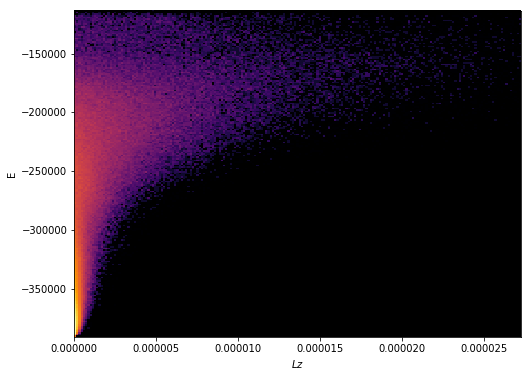

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.hist2d(Lz, E, bins=201, range = [[0., np.max(Lz)/4.],[np.min(E), np.max(E)]], norm=matplotlib.colors.LogNorm(), cmap = cmap)
ax.set_xlabel("$Lz$")
ax.set_ylabel("E")
